

#Exercise 1



In [32]:
%pylab inline
import numpy as np
import pandas as pd

pd.options.display.max_rows = 10
datay = pd.read_csv('winequality-red.csv',sep=";")

print(datay)

Populating the interactive namespace from numpy and matplotlib
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['qr', 'svd']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
print(len(datay))

#names of the columns
datay.columns

1599


Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [33]:
Aall=datay.to_numpy() # Matrix containing all the information, the last column stores y values.
print(Aall.shape)

(1599, 12)


##Split The dataset in Train and Test and then drop the last column


In [34]:
#Adding one column to the original matrix
one_columns = np.ones((Aall.shape[0], 1))

#Concatenate one_columns
AallModified = np.concatenate((one_columns, Aall), axis=1)

In [35]:
Training = AallModified[:1500, :]
Testing = AallModified[1500:, :]

In [36]:
X_train = Training[:, :-1]
y_train = Training[:, -1]

In [37]:
X_test = Testing[:, :-1]
y_test = Testing[:, -1]

##Normal Equation (A^T A)a = A^T b

In [38]:
# (A^T A)a = A^T b
def Normaleq():

  M = np.dot(X_train.T,X_train)
  tn =np.dot(X_train.T,y_train)
  a = np.linalg.solve(M,tn)
  return M, tn, a

In [39]:
M, tn, a = Normaleq()

In [40]:
y_pred = np.dot(X_test, a)

##QR

In [41]:
from scipy.linalg import qr, svd

In [58]:
#factorization in QR form of X_train
def Qrfact():
  Q, R = qr(X_train, mode="economic")
  x = np.linalg.solve(R, Q.T @ y_train)
  y_pred_qr = np.dot(X_test,x)
  return Q,x, R, y_pred_qr

In [43]:
Q,coeff_qr,R, y_pred_qr = Qrfact()

##QR with Pivot

In [44]:
def QrPiv():
  Q_piv, R_piv, P_piv = qr(X_train, mode="economic", pivoting=True)
  x = np.linalg.solve(R, Q_piv.T @ y_train)
  y_pred_qr_pivoting = np.dot(X_test, x)
  return Q_piv, x, R_piv, y_pred_qr_pivoting

In [45]:
Q_piv,coeff_qr_pivoting, R_piv, y_pred_qr_pivoting = QrPiv()

##SVD

In [46]:
def SVD():
  U, s, Vt = svd(X_train, full_matrices=False)

  components = 7 # Choosing of 7 principal component

  #Truncate of the 3 matrix to take the 7 principal components
  U_truncated = U[:, :components]
  s_truncated = s[:components]
  Vt_truncated = Vt[:components, :]


  #Create zero matrix with the shape of principal components
  S_inverse = np.zeros((U_truncated.shape[1], Vt_truncated.shape[0]))
  #Add principal components to main diagonal and then do the inverse
  S_inverse[:components, :components] = np.linalg.inv(np.diag(s_truncated))

  #V * Sigma * U ^T
  svd_pseudo_inverse = np.dot(Vt_truncated.T, S_inverse)@ U_truncated.T


  #x = V * Sigma * U^T * b (observed value) in order to obtain x
  x = np.dot(svd_pseudo_inverse, y_train)
  y_pred_svdT = np.dot(X_test, x)


  return svd_pseudo_inverse, y_pred_svdT, x


In [47]:
svd_pseudo_inverse, y_pred_svdT, coeff_svd = SVD()

In [48]:
rango = np.linalg.matrix_rank(X_train)
print("Rango della matrice:", rango)

Rango della matrice: 12


##Lapack Driver

In [49]:
import scipy as sp
import scipy.linalg as spla

#Lapack Driver Gelss
def Lapack():
  betaGelss, residualS, rankS, svS = spla.lstsq(X_train , y_train,lapack_driver='gelss')
  print ( 'beta:')
  print(betaGelss)
  print ('residuals:', residualS)
  print ('rank:', rankS)
  print ('singular values:', svS)
  y_pred_lstsq_gelss = np.dot(X_test, betaGelss)
  return y_pred_lstsq_gelss

In [50]:
y_pred_lstsq_gelss = Lapack()

beta:
[ 2.22330327e+01  2.68702621e-02 -1.12838019e+00 -2.06141685e-01
  1.22000584e-02 -1.77718503e+00  4.29357454e-03 -3.18953315e-03
 -1.81795124e+01 -3.98142390e-01  8.92474793e-01  2.77147239e-01]
residuals: 632.5384879681217
rank: 12
singular values: [2.36107780e+03 3.64036634e+02 2.54855087e+02 6.01279434e+01
 5.15230420e+01 1.37816669e+01 7.36918433e+00 5.86061394e+00
 3.94250290e+00 1.70207562e+00 1.25479367e+00 2.08555550e-02]


In [51]:
#Lapack Driver Gelsd
betaD, residualsD, rankD, svD = spla.lstsq(X_train , y_train,lapack_driver='gelsd')
print ( 'beta:')
print(betaD)
print ('residuals:', residualsD)
print ('rank:', rankD)
print ('singular values:', svD)
y_pred_lstsq_gelsD = np.dot(X_test, betaD)

beta:
[ 2.22330327e+01  2.68702621e-02 -1.12838019e+00 -2.06141685e-01
  1.22000584e-02 -1.77718503e+00  4.29357454e-03 -3.18953315e-03
 -1.81795124e+01 -3.98142390e-01  8.92474793e-01  2.77147239e-01]
residuals: 632.5384879681217
rank: 12
singular values: [2.36107780e+03 3.64036634e+02 2.54855087e+02 6.01279434e+01
 5.15230420e+01 1.37816669e+01 7.36918433e+00 5.86061394e+00
 3.94250290e+00 1.70207562e+00 1.25479367e+00 2.08555550e-02]


In [52]:
#Lapack Driver Gelsy
betaY, residualsY, rankY, svY = spla.lstsq(X_train , y_train,lapack_driver='gelsy')
print ( 'beta:')
print(betaY)
print ('residuals:', residualsY)
print ('rank:', rankY)
print ('singular values:', svY)
y_pred_lstsq_gelsY = np.dot(X_test, betaY)

beta:
[ 2.22330327e+01  2.68702621e-02 -1.12838019e+00 -2.06141685e-01
  1.22000584e-02 -1.77718503e+00  4.29357454e-03 -3.18953315e-03
 -1.81795124e+01 -3.98142390e-01  8.92474793e-01  2.77147239e-01]
residuals: []
rank: 12
singular values: None


##Accuracy

In [53]:
y_testRefactor = y_test.copy()

In [54]:
def split_class(test):
  for i, value in enumerate(test):
    if test[i] > 5.5:
      test[i] = 1
    else:
      test[i] = 0
split_class(y_testRefactor)
split_class(y_pred_lstsq_gelss)
split_class(y_pred_lstsq_gelsD)
split_class(y_pred_lstsq_gelsY)
split_class(y_pred_qr)
split_class(y_pred_qr_pivoting)
split_class(y_pred)
split_class(y_pred_svdT)

In [55]:
def accuracy(actual, pred):
  true_positive = 0
  false_negative = 0
  true_negative = 0
  false_positive = 0

  if len(actual) == len(pred):
    for i in range(len(actual)):
        if actual[i] == 1 and pred[i] == 1:
          true_positive += 1
        elif actual[i] == 1 and pred[i] == 0:
          false_negative += 1
        elif actual[i] == 0 and pred[i] == 0:
          true_negative += 1
        elif actual[i] == 0 and pred[i] == 1:
          false_positive += 1

    accuracy = (true_positive + true_negative) / len(actual)
  return accuracy, true_positive, false_negative, true_negative, false_positive

In [56]:
accuracyS, true_positiveS, false_negativeS, true_negativeS, false_positiveS = accuracy(y_testRefactor, y_pred_lstsq_gelss)
accuracyN, true_positiveN, false_negativeN, true_negativeN, false_positiveN = accuracy(y_testRefactor, y_pred)
accuracyQR, true_positiveQR, false_negativeQR, true_negativeQR, false_positiveQR = accuracy(y_testRefactor, y_pred_qr)
accuracyQRP, true_positiveQRP, false_negativeQRP, true_negativeQRP, false_positiveQRP = accuracy(y_testRefactor, y_pred_qr_pivoting)
accuracyY, true_positiveY, false_negativeY, true_negativeY, false_positiveY = accuracy(y_testRefactor, y_pred_lstsq_gelsY)
accuracyD, true_positiveD, false_negativeD, true_negativeD, false_positiveD = accuracy(y_testRefactor, y_pred_lstsq_gelsD)
accuracySVD, true_positiveSVD, false_negativeSVD, true_negativeSVD, false_positiveSVD = accuracy(y_testRefactor, y_pred_svdT)

In [57]:
print("Accuracy Normal Equations: ", accuracyN)
print("Accuracy QR Factorization: ", accuracyQR)
print("Accuracy QR with Pivot: ", accuracyQRP)
print("Accuracy SVD: ", accuracySVD)
print("Accuracy Lapack gels S: ", accuracyS)
print("Accuracy Lapack gels D: ", accuracyD)
print("Accuracy Lapack gels Y: ", accuracyY)

Accuracy Normal Equations:  0.7373737373737373
Accuracy QR Factorization:  0.7373737373737373
Accuracy QR with Pivot:  0.35353535353535354
Accuracy SVD:  0.7373737373737373
Accuracy Lapack gels S:  0.7373737373737373
Accuracy Lapack gels D:  0.7373737373737373
Accuracy Lapack gels Y:  0.7373737373737373


In [28]:
def corr_matrix(model, tn, tp, fn, fp):

  tp_matrix = [[tn, fp], [fn, tp]]

  print(f"{model}")
  for row in tp_matrix:
      print(row)

In [29]:
corr_matrix("Normal", true_positiveN,false_negativeN, true_negativeN, false_positiveN )
corr_matrix("QR", true_positiveQR,false_negativeQR, true_negativeQR, false_positiveQR )
corr_matrix("QR_pivot", true_positiveQRP,false_negativeQRP, true_negativeQRP, false_positiveQRP )
corr_matrix("SVD", true_positiveSVD,false_negativeSVD, true_negativeSVD, false_positiveSVD)
corr_matrix("GelsS", true_positiveS,false_negativeS, true_negativeS, false_positiveS )
corr_matrix("GelsD", true_positiveD,false_negativeD, true_negativeD, false_positiveD )
corr_matrix("GelsY", true_positiveY,false_negativeY, true_negativeY, false_positiveY )

Normal
[47, 15]
[26, 11]
QR
[47, 15]
[26, 11]
QR_pivot
[21, 27]
[14, 37]
SVD
[46, 14]
[27, 12]
GelsS
[47, 15]
[26, 11]
GelsD
[47, 15]
[26, 11]
GelsY
[47, 15]
[26, 11]


##Conditioning and Computation Time of the four differents approaches

In [31]:
#Normal Equations
print("\n conditioning of A ", np.linalg.cond(X_train))
print("\n conditioning of A^T A ", np.linalg.cond(M))


 conditioning of A  113210.97885071913

 conditioning of A^T A  12816725698.113


In [32]:
import time
def time_computation(method):
  start_time = time.time()
  method()
  end_time = time.time()
  execution_time = end_time - start_time
  return execution_time

In [33]:
secNormal = time_computation(Normaleq)
secQr = time_computation(Qrfact)
secQRP = time_computation(QrPiv)
secSVD = time_computation(SVD)
secLapack = time_computation(Lapack)

beta:
[ 2.22330327e+01  2.68702621e-02 -1.12838019e+00 -2.06141685e-01
  1.22000584e-02 -1.77718503e+00  4.29357454e-03 -3.18953315e-03
 -1.81795124e+01 -3.98142390e-01  8.92474793e-01  2.77147239e-01]
residuals: 632.5384879681217
rank: 12
singular values: [2.36107780e+03 3.64036634e+02 2.54855087e+02 6.01279434e+01
 5.15230420e+01 1.37816669e+01 7.36918433e+00 5.86061394e+00
 3.94250290e+00 1.70207562e+00 1.25479367e+00 2.08555550e-02]


In [34]:
print("Sec Normal: ",secNormal)
print("Sec QR: ", secQr)
print("Sec QRPivot: ", secQRP)
print("Sec SVD: ",secSVD)
print("Sec Lapack: ",secLapack)

Sec Normal:  0.0030214786529541016
Sec QR:  0.011657476425170898
Sec QRPivot:  0.0006368160247802734
Sec SVD:  0.002246379852294922
Sec Lapack:  0.0065305233001708984


#Exercise 3

## Minimum of bivariate function

Use the steepest descend method and the Newton method  to approximate  the minimum $\displaystyle{{\bf x}^{\star}=\left(\frac{1}{3},\frac{1}{3}\right)^{T}}$ of the function:
$$f({\bf x})= x_1^2 + x_1x_2 +x_2^2 - x_1 - x_2+1.$$

1. Compute the partial drivatives by hand and then write the function Grad which returns the gradient of the given $f$ evaluated at a given point ${\bf P}$ and the function Hessian which returns the Hessian matrix of the given $f$ evaluated at a given point ${\bf P}$.

In [35]:
def Grad (x1,x2):
  df_x1 = 2*x1 + x2 -1
  df_x2 = x1 + 2*x2 -1
  return np.array([df_x1,df_x2])

In [36]:
def Hessian(x1, x2):
    d2f_dx1dx1 = 2
    d2f_dx1dx2 = 1
    d2f_dx2dx1 = 1
    d2f_dx2dx2 = 2
    hessian_matrix = np.array([[d2f_dx1dx1, d2f_dx1dx2],
                               [d2f_dx2dx1, d2f_dx2dx2]])
    return hessian_matrix

#Take P (2,3)
x1 = 2
x2 = 3

gradient_at_point = Grad(x1, x2)
hessian_at_point = Hessian(x1, x2)

print("Gradient at the point:", gradient_at_point)
print("Hessian matrix at the point:\n", hessian_at_point)


Gradient at the point: [6 7]
Hessian matrix at the point:
 [[2 1]
 [1 2]]


#Excercises 2

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
def remove_stopwords(sentence_list):
    stop_words = set(stopwords.words('english'))

    cleaned_sentences = []
    for sentence in sentence_list:
        words = nltk.word_tokenize(sentence)  # Tokenizza la frase in parole
        filtered_words = [word for word in words if word.lower() not in stop_words]
        cleaned_sentence = ' '.join(filtered_words)
        cleaned_sentences.append(cleaned_sentence)

    return cleaned_sentences

In [8]:
import numpy as np
import sklearn
import sklearn.feature_extraction
import scipy.linalg
from scipy.linalg import *
import scipy.linalg as spl
np.set_printoptions(suppress=True)
vectorizer = sklearn.feature_extraction.text.CountVectorizer(min_df=1)
documents = [
'The rank of a matrix is the maximum number of linearly independent columns.',
'The column space of a matrix A is called range of A.',
'The inverse of an orthogonal matrix is its transpose.',
'If A is a singular matrix then it has at least one null eigenvalue.',
'The product of an orthogonal matrix and its traspose is the identity matrix.',
'The rank of a matrix is the maximum number of  linearly independent rows.',
'A set of orthogonal vectors is a linearly independent set.',
'The spectrum of a matrix is the set of all its distinct eigenvalues.',
'The eigenvalues of a matrix are the roots of the characteristic polynomial.',
'The columns of an orthogonal matrix are a set of orthogonal vectors.',
'A normed vectorial space is a space with an inner product norm.',
'Similar matrices have the same spectrum.',
'Matrices not similar to a diagonal matrix are called defective.',
]

documents = remove_stopwords(documents)

X = vectorizer.fit_transform(documents).toarray()
print('vectorizer.vocabulary_: {0}'.format(vectorizer.vocabulary_))
A=X.T
# query vectors
query1text = ['rank of a matrix?']
query1 = vectorizer.transform(query1text).toarray()
query1 = query1.T
query2text = ['spectrum']
query2 = vectorizer.transform(query2text).toarray()
query2 = query2.T

vectorizer.vocabulary_: {'rank': 27, 'matrix': 16, 'maximum': 17, 'number': 21, 'linearly': 14, 'independent': 10, 'columns': 3, 'column': 2, 'space': 33, 'called': 0, 'range': 26, 'inverse': 12, 'orthogonal': 23, 'transpose': 35, 'singular': 32, 'least': 13, 'one': 22, 'null': 20, 'eigenvalue': 7, 'product': 25, 'traspose': 36, 'identity': 9, 'rows': 29, 'set': 30, 'vectors': 38, 'spectrum': 34, 'distinct': 6, 'eigenvalues': 8, 'roots': 28, 'characteristic': 1, 'polynomial': 24, 'normed': 19, 'vectorial': 37, 'inner': 11, 'norm': 18, 'similar': 31, 'matrices': 15, 'diagonal': 5, 'defective': 4}


In [9]:
cosAM = []
for i in range(13):
  cosA = np.dot(A.T[i, :], query1)/np.dot(np.linalg.norm(A,2),np.linalg.norm(query1,2))
  cosAM.append(cosA)

cosAM = np.array(cosAM)
maxIndex = np.where(cosAM == np.max(cosAM))[0] #trovo gli indici nell'array con valore massimo

print("I documenti con coseno di similarità maggiore tra A e query1 sono: \n")
for i in maxIndex:
  print(documents[i])

I documenti con coseno di similarità maggiore tra A e query1 sono: 

rank matrix maximum number linearly independent columns .
product orthogonal matrix traspose identity matrix .
rank matrix maximum number linearly independent rows .


In [10]:
cosAM = []
for i in range(13):
  cosA = np.dot(A.T[i, :], query2)/np.dot(np.linalg.norm(A,2),np.linalg.norm(query1,2))
  cosAM.append(cosA)

cosAM = np.array(cosAM)
maxIndex = np.where(cosAM == np.max(cosAM))[0]

print("I documenti con coseno di similarità maggiore tra A e query1 sono: \n")
for i in maxIndex:
  print(documents[i])

I documenti con coseno di similarità maggiore tra A e query1 sono: 

spectrum matrix set distinct eigenvalues .
Similar matrices spectrum .


In [11]:
#QR factorization with pivot
Q,R,P=spl.qr(A,mode='economic',pivoting=True)
AReconstructed = np.dot(Q,R)


In [14]:
cosQRq1 = np.dot(R.T,np.dot(Q.T,query1))/np.dot(np.linalg.norm(R,2),np.linalg.norm(np.dot(Q.T,query1),2))
cosQRq2 = np.dot(R.T,np.dot(Q.T,query2))/np.dot(np.linalg.norm(R,2),np.linalg.norm(np.dot(Q.T,query2),2))

In [15]:
for i in range(13):
    print(f"Similarità con QR e query1 {i + 1}: QR: {cosQRq1[i]}")

Similarità con QR e query1 1: QR: [0.]
Similarità con QR e query1 2: QR: [0.]
Similarità con QR e query1 3: QR: [0.40313714]
Similarità con QR e query1 4: QR: [0.40313714]
Similarità con QR e query1 5: QR: [0.20156857]
Similarità con QR e query1 6: QR: [0.20156857]
Similarità con QR e query1 7: QR: [0.20156857]
Similarità con QR e query1 8: QR: [0.20156857]
Similarità con QR e query1 9: QR: [0.20156857]
Similarità con QR e query1 10: QR: [0.20156857]
Similarità con QR e query1 11: QR: [0.20156857]
Similarità con QR e query1 12: QR: [0.]
Similarità con QR e query1 13: QR: [0.40313714]


In [16]:
for i in range(13):
    print(f"Similarità con QR e query2 {i + 1}: QR: {cosQRq2[i]}")

Similarità con QR e query2 1: QR: [0.]
Similarità con QR e query2 2: QR: [0.]
Similarità con QR e query2 3: QR: [0.]
Similarità con QR e query2 4: QR: [0.]
Similarità con QR e query2 5: QR: [0.]
Similarità con QR e query2 6: QR: [0.]
Similarità con QR e query2 7: QR: [0.]
Similarità con QR e query2 8: QR: [0.]
Similarità con QR e query2 9: QR: [0.27848985]
Similarità con QR e query2 10: QR: [0.]
Similarità con QR e query2 11: QR: [0.]
Similarità con QR e query2 12: QR: [0.27848985]
Similarità con QR e query2 13: QR: [-0.]


In [17]:
#SVD decomposition
U,s,V=scipy.linalg.svd(A, full_matrices = False)

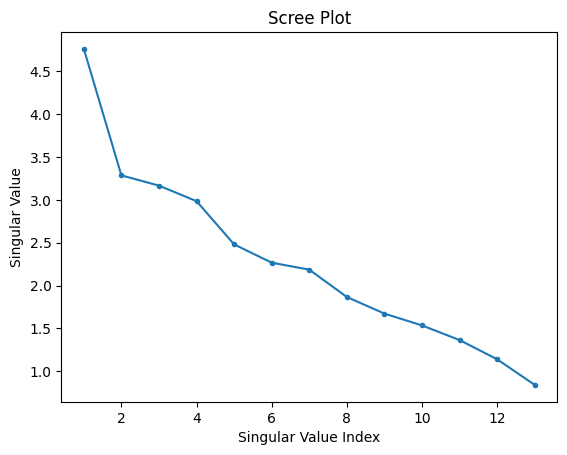

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(s) + 1), s, marker='.')
plt.title("Scree Plot")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")
plt.show()

In [19]:
rango = np.linalg.matrix_rank(A)
print("Rango della matrice:", rango)

Rango della matrice: 13


In [20]:
#the rank is 13, so we choose the 4th singular values in order to reduce the matrix
r = 4
Ur = U[:, :r]
Sr = np.diag(s[:r])
Vtr = V[:r, :]
reconstructed_matrix = np.dot(np.dot(Ur, Sr), Vtr) #Reconstructed matrix

In [21]:
cosSVDq1 = np.dot(np.dot(Sr, Vtr).T,np.dot(Ur.T,query1))/np.dot(np.linalg.norm(np.dot(Sr, Vtr),2),np.linalg.norm(query1,2))
cosSVDq2 = np.dot(np.dot(Sr, Vtr).T,np.dot(Ur.T,query2))/np.dot(np.linalg.norm(np.dot(Sr, Vtr),2),np.linalg.norm(query2,2))

In [22]:
for i in range(13):
    print(f"Similarità con SVD e query1 {i + 1}: SVD: {cosSVDq1[i]}")

Similarità con SVD e query1 1: SVD: [0.29034592]
Similarità con SVD e query1 2: SVD: [0.15460592]
Similarità con SVD e query1 3: SVD: [0.13288465]
Similarità con SVD e query1 4: SVD: [0.16605544]
Similarità con SVD e query1 5: SVD: [0.27092761]
Similarità con SVD e query1 6: SVD: [0.29213568]
Similarità con SVD e query1 7: SVD: [0.04297613]
Similarità con SVD e query1 8: SVD: [0.13306436]
Similarità con SVD e query1 9: SVD: [0.15644449]
Similarità con SVD e query1 10: SVD: [0.13273673]
Similarità con SVD e query1 11: SVD: [0.0043067]
Similarità con SVD e query1 12: SVD: [0.03987037]
Similarità con SVD e query1 13: SVD: [0.19086587]


In [23]:
for i in range(13):
    print(f"Similarità con SVD e query2 {i + 1}: SVD: {cosSVDq2[i]}")

Similarità con SVD e query2 1: SVD: [-0.00347886]
Similarità con SVD e query2 2: SVD: [0.01496223]
Similarità con SVD e query2 3: SVD: [0.02559102]
Similarità con SVD e query2 4: SVD: [0.02563732]
Similarità con SVD e query2 5: SVD: [0.04313035]
Similarità con SVD e query2 6: SVD: [-0.00515728]
Similarità con SVD e query2 7: SVD: [0.00011426]
Similarità con SVD e query2 8: SVD: [0.02401589]
Similarità con SVD e query2 9: SVD: [0.02479731]
Similarità con SVD e query2 10: SVD: [0.03004166]
Similarità con SVD e query2 11: SVD: [-0.02207199]
Similarità con SVD e query2 12: SVD: [0.0095002]
Similarità con SVD e query2 13: SVD: [0.03053279]
